## Colab Setup

In [26]:
import sys

IS_COLAB = 'google.colab' in sys.modules
print(f"Running in Google Colab: {IS_COLAB}")

Running in Google Colab: True


In [27]:
import os
import sys

if IS_COLAB:
    print("Running in Google Colab environment.")
    if os.path.exists('/content/aai521_3proj'):
        print("Repository already exists. Pulling latest changes...")
        %cd /content/aai521_3proj
        !git pull
    else:
        print("Cloning repository...")
        !git clone https://github.com/swapnilprakashpatil/aai521_3proj.git
        %cd aai521_3proj    
    %pip install -r requirements.txt
    sys.path.append('/content/aai521_3proj/src')
    %ls
else:
    print("Running in local environment. Installing packages...")
    %pip install -r ../requirements.txt
    sys.path.append('../src')

Running in Google Colab environment.
Repository already exists. Pulling latest changes...
/content/aai521_3proj
Already up to date.
Already up to date.
dataset/  notebooks/  requirements.txt  src/
dataset/  notebooks/  requirements.txt  src/


## 1. Setup & Imports

In [28]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

# Reload modules to pick up latest changes
import importlib
if 'dataset' in sys.modules:
    importlib.reload(sys.modules['dataset'])
if 'models' in sys.modules:
    importlib.reload(sys.modules['models'])
if 'config' in sys.modules:
    importlib.reload(sys.modules['config'])

# Import custom modules
import config
from dataset import create_dataloaders, FloodDataset
from models import create_model, UNetPlusPlus, DeepLabV3Plus, SegFormer
from losses import create_loss_function
from metrics import MetricsTracker, SegmentationMetrics
from trainer import Trainer
from experiment_tracking import ExperimentLogger, ExperimentComparator

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB
CUDA memory: 42.47 GB


## 2. Data Loading & Exploration

In [ ]:
# Create dataloaders
print("Creating dataloaders...")
train_loader, val_loader, test_loader = create_dataloaders(
    train_dir=config.PROCESSED_TRAIN_DIR,
    val_dir=config.PROCESSED_VAL_DIR,
    test_dir=config.PROCESSED_TEST_DIR,
    batch_size=8,  # Optimized batch size for GPU
    num_workers=4  # Parallel data loading for speed
)

print(f"\nDataset sizes:")
print(f"  Training: {len(train_loader.dataset)} patches ({len(train_loader)} batches)")
print(f"  Validation: {len(val_loader.dataset)} patches ({len(val_loader)} batches)")
print(f"  Test: {len(test_loader.dataset)} patches ({len(test_loader)} batches)")

# Get class weights
class_weights = train_loader.dataset.get_class_weights()
print(f"\nClass weights: {class_weights}")

# Get class distribution
class_dist = train_loader.dataset.get_class_distribution()
print(f"\nClass distribution:")
for i, (class_name, count) in enumerate(zip(config.CLASS_NAMES, class_dist)):
    percentage = (count / class_dist.sum()) * 100
    print(f"  {class_name}: {count:,} ({percentage:.2f}%)")

Creating dataloaders...
Loaded train dataset: 7285 samples

Class distribution (train):
  Class 0: 1,860,991,567 pixels (97.45%), weight: 0.1466
  Class 1: 31,784,864 pixels (1.66%), weight: 8.5832
  Class 2: 8,851,035 pixels (0.46%), weight: 30.8232
  Class 3: 0 pixels (0.00%), weight: 0.0000
  Class 4: 0 pixels (0.00%), weight: 0.0000
  Class 5: 1,849,705 pixels (0.10%), weight: 147.4922
  Class 6: 6,241,869 pixels (0.33%), weight: 43.7076
Loaded val dataset: 1069 samples

Class distribution (val):
  Class 0: 274,496,415 pixels (97.95%), weight: 0.1458
  Class 1: 3,162,106 pixels (1.13%), weight: 12.6603
  Class 2: 1,445,230 pixels (0.52%), weight: 27.7002
  Class 3: 0 pixels (0.00%), weight: 0.0000
  Class 4: 0 pixels (0.00%), weight: 0.0000
  Class 5: 300,377 pixels (0.11%), weight: 133.2763
  Class 6: 827,808 pixels (0.30%), weight: 48.3604
Loaded test dataset: 3573 samples

Class distribution (test):
  Class 0: 936,640,512 pixels (100.00%), weight: 0.1429
  Class 1: 0 pixels (0.0

### Visualize Class Distribution

### Class Imbalance Handling

The dataset is **heavily imbalanced** (97.4% background vs 2.6% flood/other classes). This is addressed through:

1. **Square-Root Inverse Frequency Weighting** (in `dataset.py`)
   - Less aggressive than inverse frequency
   - Prevents extreme weights that cause training instability
   - Normalizes weights to maintain loss scale

2. **Focal Loss** (gamma=2.0, weight=1.5 in combined loss)
   - Specifically designed for class imbalance
   - Down-weights easy examples (background)
   - Focuses on hard-to-classify minority classes

3. **Dice Loss** (weight=1.0 in combined loss)
   - Naturally handles imbalance through overlap metric
   - Works well for segmentation tasks

4. **Cross-Entropy Loss** (weight=0.5 in combined loss, class-weighted)
   - Reduced weight to prevent overfitting to majority class
   - Uses normalized class weights

**Combined Loss = 0.5 × CE + 1.0 × Dice + 1.5 × Focal**

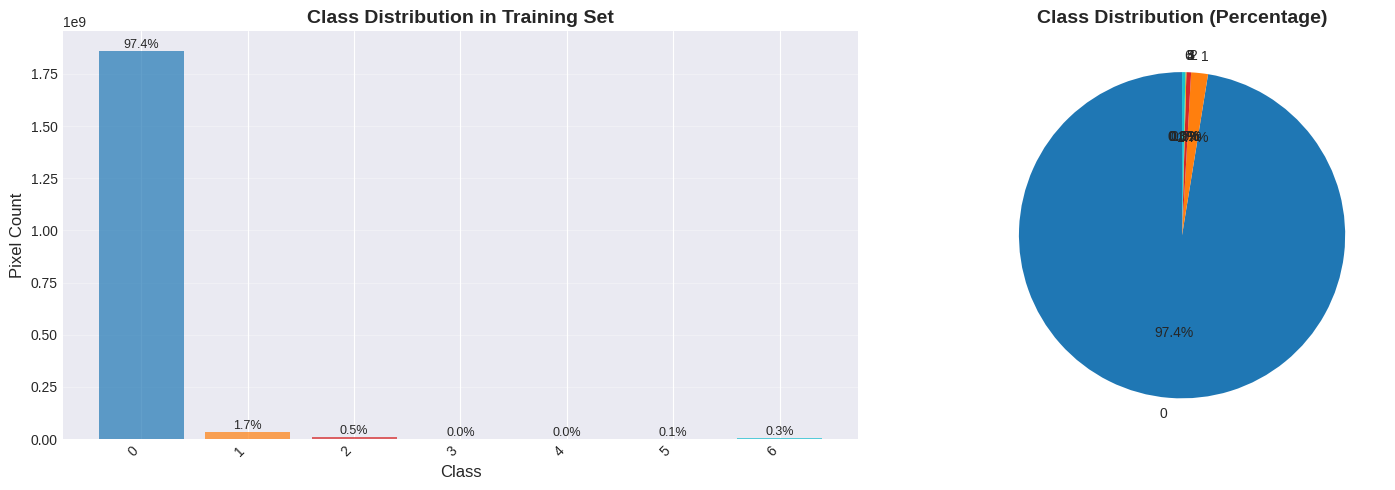

In [30]:
# Plot class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot
colors = plt.cm.tab10(np.linspace(0, 1, len(config.CLASS_NAMES)))
bars = ax1.bar(range(len(config.CLASS_NAMES)), class_dist, color=colors, alpha=0.7)
ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('Pixel Count', fontsize=12)
ax1.set_title('Class Distribution in Training Set', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(config.CLASS_NAMES)))
ax1.set_xticklabels(config.CLASS_NAMES, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (bar, count) in enumerate(zip(bars, class_dist)):
    height = bar.get_height()
    percentage = (count / class_dist.sum()) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{percentage:.1f}%',
            ha='center', va='bottom', fontsize=9)

# Pie chart
ax2.pie(class_dist, labels=config.CLASS_NAMES, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Visualize Sample Data

Batch shape: torch.Size([4, 6, 512, 512])
Mask shape: torch.Size([4, 512, 512])
Image range: [-2.118, -2.018]
Mask classes: [0, 5]


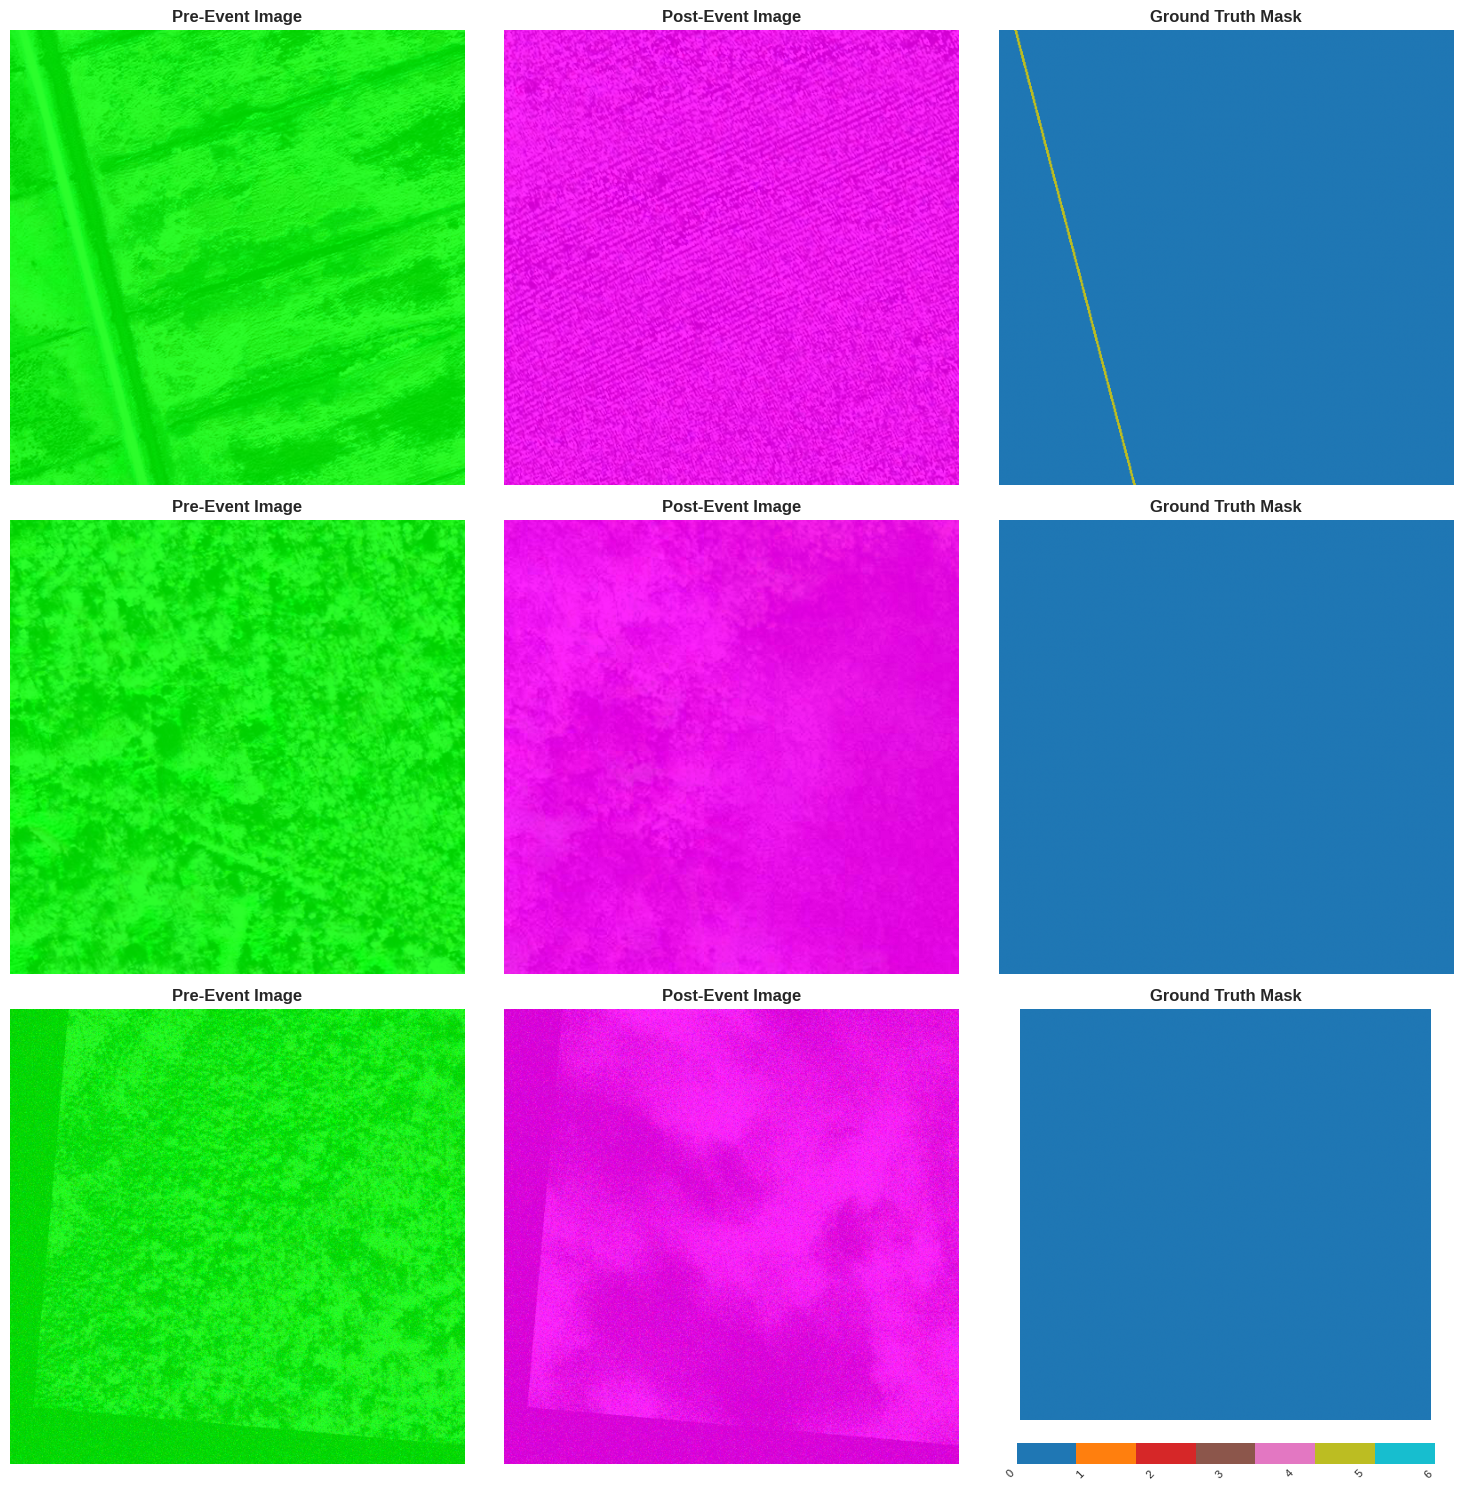

In [31]:
# Get a batch of training data
train_iter = iter(train_loader)
batch = next(train_iter)
images = batch['image']
masks = batch['mask']

print(f"Batch shape: {images.shape}")
print(f"Mask shape: {masks.shape}")
print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")
print(f"Mask classes: {masks.unique().tolist()}")

# Visualize samples
def visualize_samples(images, masks, num_samples=3):
    """Visualize pre/post images and masks."""
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    # Color map for masks
    cmap = plt.cm.get_cmap('tab10', len(config.CLASS_NAMES))
    
    for i in range(num_samples):
        # Pre-event image (first 3 channels)
        pre_img = images[i, :3].permute(1, 2, 0).numpy()
        pre_img = (pre_img - pre_img.min()) / (pre_img.max() - pre_img.min() + 1e-8)
        
        # Post-event image (last 3 channels)
        post_img = images[i, 3:].permute(1, 2, 0).numpy()
        post_img = (post_img - post_img.min()) / (post_img.max() - post_img.min() + 1e-8)
        
        # Mask
        mask = masks[i].numpy()
        
        # Plot pre-event
        axes[i, 0].imshow(pre_img)
        axes[i, 0].set_title('Pre-Event Image', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')
        
        # Plot post-event
        axes[i, 1].imshow(post_img)
        axes[i, 1].set_title('Post-Event Image', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')
        
        # Plot mask
        mask_plot = axes[i, 2].imshow(mask, cmap=cmap, vmin=0, vmax=len(config.CLASS_NAMES)-1)
        axes[i, 2].set_title('Ground Truth Mask', fontsize=12, fontweight='bold')
        axes[i, 2].axis('off')
        
        # Add colorbar to last mask
        if i == num_samples - 1:
            cbar = plt.colorbar(mask_plot, ax=axes[i, 2], orientation='horizontal', 
                              pad=0.05, fraction=0.046)
            cbar.set_ticks(range(len(config.CLASS_NAMES)))
            cbar.set_ticklabels(config.CLASS_NAMES, rotation=45, ha='right', fontsize=8)
    
    plt.tight_layout()
    plt.show()

visualize_samples(images, masks, num_samples=3)

## 3. Model Architecture Overview

In [32]:
# Create models for architecture overview
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models_info = []

for model_name in ['unet++', 'deeplabv3+', 'segformer']:
    model = create_model(
        model_name=model_name,
        in_channels=6,
        num_classes=config.NUM_CLASSES,
        **config.MODEL_CONFIGS.get(model_name, {})
    )
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    models_info.append({
        'Model': model_name.upper(),
        'Total Parameters': f"{total_params:,}",
        'Trainable Parameters': f"{trainable_params:,}",
        'Size (MB)': f"{total_params * 4 / 1e6:.2f}"
    })
    
    del model

# Display as table
models_df = pd.DataFrame(models_info)
print("\n" + "="*80)
print("MODEL ARCHITECTURE COMPARISON")
print("="*80)
print(models_df.to_string(index=False))
print("="*80)

UNet++ initialized:
  Encoder: resnet34
  Input channels: 6
  Output classes: 7
  Pretrained: imagenet
  Deep supervision: False
DeepLabV3+ initialized:
  Encoder: resnet50
  Input channels: 6
  Output classes: 7
  Output stride: 16
  Pretrained: imagenet
DeepLabV3+ initialized:
  Encoder: resnet50
  Input channels: 6
  Output classes: 7
  Output stride: 16
  Pretrained: imagenet


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([7]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([7, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegFormer initialized:
  Model: nvidia/segformer-b0-finetuned-ade-512-512
  Input channels: 6
  Output classes: 7
  Pretrained: True

MODEL ARCHITECTURE COMPARISON
     Model Total Parameters Trainable Parameters Size (MB)
    UNET++       26,088,887           26,088,887    104.36
DEEPLABV3+       26,688,535           26,688,535    106.75
 SEGFORMER        3,720,647            3,720,647     14.88


## 4. Training Configuration

In [ ]:
# Training configuration
TRAINING_CONFIG = {
    'batch_size': 8,  # Increased for better GPU utilization
    'num_epochs': 30,
    'learning_rate': 2e-4,  # Slightly higher LR for faster convergence
    'weight_decay': 1e-4,  # Stronger regularization
    'use_amp': True,
    'gradient_clip': 1.0,
    'early_stopping_patience': 8,  # Reduced patience for faster training
    'loss_type': 'combined',
    'scheduler_type': 'cosine',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'gradient_accumulation_steps': 2,  # Effective batch size = 8*2=16
    'print_every_n_epochs': 5  # Reduce console output
}

# Display configuration
print("\n" + "="*80)
print("TRAINING CONFIGURATION")
print("="*80)
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")
print("="*80)


TRAINING CONFIGURATION
  batch_size: 4
  num_epochs: 30
  learning_rate: 0.0001
  weight_decay: 1e-05
  use_amp: True
  gradient_clip: 1.0
  early_stopping_patience: 10
  loss_type: combined
  scheduler_type: cosine
  device: cuda


## 5. Model Training

We'll train each model and track metrics using TensorBoard.

In [ ]:
def train_single_model(model_name, config_dict, train_loader, val_loader, class_weights):
    """
    Train a single model and return training history.
    
    Args:
        model_name: Name of the model
        config_dict: Training configuration
        train_loader: Training data loader
        val_loader: Validation data loader
        class_weights: Class weights for loss
    
    Returns:
        dict: Training history
    """
    print(f"\n{'='*80}")
    print(f"Training {model_name.upper()}")
    print(f"{'='*80}\n")
    
    # Force CUDA optimizations
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True  # Auto-tune for optimal performance
        torch.backends.cuda.matmul.allow_tf32 = True  # Use TensorFloat-32 for faster matmul
        torch.backends.cudnn.allow_tf32 = True
        print(f"✓ CUDA optimizations enabled (cuDNN benchmark, TF32)")
    
    # Create output directory
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_dir = Path('../outputs/training') / f'{model_name}_{timestamp}'
    output_dir.mkdir(parents=True, exist_ok=True)
    checkpoint_dir = output_dir / 'checkpoints'
    checkpoint_dir.mkdir(exist_ok=True)
    
    # Create model
    model = create_model(
        model_name=model_name,
        in_channels=6,
        num_classes=config.NUM_CLASSES,
        **config.MODEL_CONFIGS.get(model_name, {})
    )
    model = model.to(config_dict['device'])
    
    # Use torch.compile for PyTorch 2.0+ speedup (if available)
    if hasattr(torch, 'compile') and config_dict['device'] == 'cuda':
        try:
            model = torch.compile(model, mode='reduce-overhead')
            print(f"✓ Model compiled with torch.compile for faster training")
        except:
            print(f"⚠ torch.compile not available, using standard model")
    
    # Create loss function
    loss_fn = create_loss_function(
        loss_type=config_dict['loss_type'],
        num_classes=config.NUM_CLASSES,
        class_weights=class_weights.to(config_dict['device']),
        device=config_dict['device']
    )
    
    # Create optimizer with improved settings
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config_dict['learning_rate'],
        weight_decay=config_dict['weight_decay'],
        betas=(0.9, 0.999),  # Default AdamW betas
        eps=1e-8
    )
    
    # Create scheduler with warmup
    from torch.optim.lr_scheduler import OneCycleLR
    scheduler = OneCycleLR(
        optimizer,
        max_lr=config_dict['learning_rate'],
        epochs=config_dict['num_epochs'],
        steps_per_epoch=len(train_loader) // config_dict.get('gradient_accumulation_steps', 1),
        pct_start=0.1,  # 10% warmup
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=1000.0
    )
    
    # Create experiment logger
    logger = ExperimentLogger(
        log_dir=Path('../outputs/tensorboard'),
        experiment_name=f'{model_name}_{timestamp}'
    )
    logger.log_hyperparameters(config_dict)
    
    # Create trainer
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_fn=loss_fn,
        num_classes=config.NUM_CLASSES,
        device=config_dict['device'],
        checkpoint_dir=checkpoint_dir,
        experiment_name=f'{model_name}_{timestamp}',
        use_amp=config_dict['use_amp'],
        gradient_clip_val=config_dict['gradient_clip'],
        early_stopping_patience=config_dict['early_stopping_patience'],
        gradient_accumulation_steps=config_dict.get('gradient_accumulation_steps', 1),
        class_names=config.CLASS_NAMES
    )
    
    # Train with progress tracking
    print(f"Starting training...")
    print(f"  Batch size: {config_dict['batch_size']} (effective: {config_dict.get('gradient_accumulation_steps', 1) * config_dict['batch_size']})")
    print(f"  Total epochs: {config_dict['num_epochs']}")
    print(f"  Early stopping patience: {config_dict['early_stopping_patience']}")
    print(f"  Using AMP: {config_dict['use_amp']}")
    print(f"  Print interval: Every {config_dict.get('print_every_n_epochs', 5)} epochs\n")
    
    history = trainer.train(num_epochs=config_dict['num_epochs'])
    
    # Print final summary
    best_epoch = max(range(len(history['val_iou'])), key=lambda i: history['val_iou'][i])
    print(f"\n{'='*80}")
    print(f"TRAINING COMPLETE - {model_name.upper()}")
    print(f"{'='*80}")
    print(f"Best epoch: {best_epoch + 1}/{len(history['val_iou'])}")
    print(f"Best validation metrics:")
    print(f"  IoU:  {history['val_iou'][best_epoch]:.4f}")
    print(f"  Dice: {history['val_dice'][best_epoch]:.4f}")
    print(f"  F1:   {history['val_f1'][best_epoch]:.4f}")
    print(f"Final validation metrics:")
    print(f"  IoU:  {history['val_iou'][-1]:.4f}")
    print(f"  Dice: {history['val_dice'][-1]:.4f}")
    print(f"  F1:   {history['val_f1'][-1]:.4f}")
    print(f"{'='*80}\n")
    
    # Log metrics to TensorBoard (all epochs)
    for epoch in range(len(history['train_loss'])):
        logger.log_scalar('Loss/train', history['train_loss'][epoch], epoch)
        logger.log_scalar('Loss/val', history['val_loss'][epoch], epoch)
        logger.log_scalar('IoU/train', history['train_iou'][epoch], epoch)
        logger.log_scalar('IoU/val', history['val_iou'][epoch], epoch)
        logger.log_scalar('Dice/train', history['train_dice'][epoch], epoch)
        logger.log_scalar('Dice/val', history['val_dice'][epoch], epoch)
        logger.log_scalar('F1/train', history['train_f1'][epoch], epoch)
        logger.log_scalar('F1/val', history['val_f1'][epoch], epoch)
    
    logger.close()
    
    # Convert numpy types to native Python types for JSON serialization
    history_json = {}
    for key, values in history.items():
        if isinstance(values, list):
            history_json[key] = [float(v) if hasattr(v, 'item') else v for v in values]
        else:
            history_json[key] = values
    
    # Save history
    with open(output_dir / 'training_history.json', 'w') as f:
        json.dump(history_json, f, indent=2)
    
    print(f"Checkpoints saved to: {checkpoint_dir}")
    print(f"Training history saved to: {output_dir / 'training_history.json'}\n")
    
    return history, output_dir

### Train U-Net++

In [ ]:
# Train U-Net++
unet_history, unet_output_dir = train_single_model(
    'unet++',
    TRAINING_CONFIG,
    train_loader,
    val_loader,
    class_weights
)


Training UNET++

UNet++ initialized:
  Encoder: resnet34
  Input channels: 6
  Output classes: 7
  Pretrained: imagenet
  Deep supervision: False
Combined Loss initialized:
  CE weight:    1.0
  Dice weight:  1.0
  Focal weight: 0.0
  Class weights: [1.4659765e-01 8.5832367e+00 3.0823175e+01 0.0000000e+00 0.0000000e+00
 1.4749217e+02 4.3707584e+01]

Trainer initialized:
  Experiment: unet++_20251130_235825
  Device: cuda
  Mixed precision: True
  Gradient clipping: 1.0
  Early stopping patience: 10
  Checkpoint dir: ../outputs/training/unet++_20251130_235825/checkpoints/unet++_20251130_235825

Starting training for 30 epochs

UNet++ initialized:
  Encoder: resnet34
  Input channels: 6
  Output classes: 7
  Pretrained: imagenet
  Deep supervision: False
Combined Loss initialized:
  CE weight:    1.0
  Dice weight:  1.0
  Focal weight: 0.0
  Class weights: [1.4659765e-01 8.5832367e+00 3.0823175e+01 0.0000000e+00 0.0000000e+00
 1.4749217e+02 4.3707584e+01]

Trainer initialized:
  Experim

Epoch 1 [Val]: 100%|██████████| 268/268 [00:27<00:00,  9.64it/s, loss=5.3483, avg_loss=5.5495]




Epoch 1 Summary:
  Train Loss: 2.1714 | Val Loss: 5.5495
  Train IoU:  0.1489 | Val IoU:  0.0042
  Train Dice: 0.1954 | Val Dice: 0.0084
  Train F1:   0.1396 | Val F1:   0.0060
  LR: 0.000100
  ✓ Best model saved (Val IoU: 0.0042)
  Epoch time: 432.21s

  ✓ Best model saved (Val IoU: 0.0042)
  Epoch time: 432.21s



Epoch 2 [Val]: 100%|██████████| 268/268 [00:27<00:00,  9.70it/s, loss=3.7532, avg_loss=3.5685]




Epoch 2 Summary:
  Train Loss: 1.8869 | Val Loss: 3.5685
  Train IoU:  0.2027 | Val IoU:  0.0018
  Train Dice: 0.2562 | Val Dice: 0.0036
  Train F1:   0.1830 | Val F1:   0.0026
  LR: 0.000100
  Epoch time: 430.00s

  Epoch time: 430.00s



Epoch 3 [Val]: 100%|██████████| 268/268 [00:27<00:00,  9.84it/s, loss=2.2984, avg_loss=2.9228]




Epoch 3 Summary:
  Train Loss: 1.5842 | Val Loss: 2.9228
  Train IoU:  0.2114 | Val IoU:  0.0105
  Train Dice: 0.2704 | Val Dice: 0.0200
  Train F1:   0.1932 | Val F1:   0.0143
  LR: 0.000099
  ✓ Best model saved (Val IoU: 0.0105)
  Epoch time: 431.32s

  ✓ Best model saved (Val IoU: 0.0105)
  Epoch time: 431.32s



Epoch 4 [Train]:  10%|▉         | 175/1821 [00:38<05:57,  4.60it/s, loss=1.3805, avg_loss=1.4528]

### Train DeepLabV3+

In [ ]:
# Train DeepLabV3+
deeplab_history, deeplab_output_dir = train_single_model(
    'deeplabv3+',
    TRAINING_CONFIG,
    train_loader,
    val_loader,
    class_weights
)

### Train SegFormer

In [ ]:
# Train SegFormer
segformer_history, segformer_output_dir = train_single_model(
    'segformer',
    TRAINING_CONFIG,
    train_loader,
    val_loader,
    class_weights
)

## 6. Training Metrics Visualization

In [ ]:
def plot_training_history(history, model_name, save_path=None):
    """
    Plot training history for a single model.
    
    Args:
        history: Training history dictionary
        model_name: Name of the model
        save_path: Optional path to save figure
    """
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{model_name} - Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # IoU plot
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(epochs, history['train_iou'], 'b-', label='Train IoU', linewidth=2)
    ax2.plot(epochs, history['val_iou'], 'r-', label='Val IoU', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('IoU', fontsize=11)
    ax2.set_title('Mean IoU', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Dice plot
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(epochs, history['train_dice'], 'b-', label='Train Dice', linewidth=2)
    ax3.plot(epochs, history['val_dice'], 'r-', label='Val Dice', linewidth=2)
    ax3.set_xlabel('Epoch', fontsize=11)
    ax3.set_ylabel('Dice', fontsize=11)
    ax3.set_title('Mean Dice Coefficient', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    plt.suptitle(f'{model_name} Training Metrics', fontsize=16, fontweight='bold', y=0.995)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print best metrics
    best_epoch = max(range(len(history['val_iou'])), key=lambda i: history['val_iou'][i])
    print(f"\n{'='*80}")
    print(f"{model_name} - Best Validation Metrics (Epoch {best_epoch + 1})")
    print(f"{'='*80}")
    print(f"Mean IoU: {history['val_iou'][best_epoch]:.4f}")
    print(f"Mean Dice: {history['val_dice'][best_epoch]:.4f}")
    print(f"Mean F1: {history['val_f1'][best_epoch]:.4f}")
    print(f"{'='*80}\n")

In [ ]:
# Plot training history for each model
plot_training_history(unet_history, 'U-Net++', unet_output_dir / 'training_history.png')

In [ ]:
plot_training_history(deeplab_history, 'DeepLabV3+', deeplab_output_dir / 'training_history.png')

In [ ]:
plot_training_history(segformer_history, 'SegFormer', segformer_output_dir / 'training_history.png')

## 7. Model Comparison

In [ ]:
# Compare all models
def compare_models(histories, model_names):
    """
    Compare multiple models.
    
    Args:
        histories: List of training histories
        model_names: List of model names
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Plot 1: Validation Loss
    for history, name, color in zip(histories, model_names, colors):
        epochs = range(1, len(history['val_loss']) + 1)
        axes[0, 0].plot(epochs, history['val_loss'], label=name, linewidth=2, color=color)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Validation IoU
    for history, name, color in zip(histories, model_names, colors):
        epochs = range(1, len(history['val_iou']) + 1)
        axes[0, 1].plot(epochs, history['val_iou'], label=name, linewidth=2, color=color)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('IoU', fontsize=12)
    axes[0, 1].set_title('Validation Mean IoU Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Validation Dice
    for history, name, color in zip(histories, model_names, colors):
        epochs = range(1, len(history['val_dice']) + 1)
        axes[1, 0].plot(epochs, history['val_dice'], label=name, linewidth=2, color=color)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Dice', fontsize=12)
    axes[1, 0].set_title('Validation Mean Dice Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Best Metrics Bar Chart
    x = np.arange(len(model_names))
    width = 0.25
    
    # Get best metrics for each model
    iou_values = []
    dice_values = []
    f1_values = []
    
    for history in histories:
        best_epoch = max(range(len(history['val_iou'])), key=lambda i: history['val_iou'][i])
        iou_values.append(history['val_iou'][best_epoch])
        dice_values.append(history['val_dice'][best_epoch])
        f1_values.append(history['val_f1'][best_epoch])
    
    axes[1, 1].bar(x - width, iou_values, width, label='IoU', alpha=0.8)
    axes[1, 1].bar(x, dice_values, width, label='Dice', alpha=0.8)
    axes[1, 1].bar(x + width, f1_values, width, label='F1', alpha=0.8)
    
    axes[1, 1].set_xlabel('Model', fontsize=12)
    axes[1, 1].set_ylabel('Score', fontsize=12)
    axes[1, 1].set_title('Best Validation Metrics Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(model_names)
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print comparison table
    print(f"\n{'='*100}")
    print("MODEL COMPARISON - BEST VALIDATION METRICS")
    print(f"{'='*100}")
    print(f"{'Model':<20} {'Best Epoch':<12} {'Mean IoU':<12} {'Mean Dice':<12} {'Mean F1':<12}")
    print(f"{'-'*100}")
    
    for name, history in zip(model_names, histories):
        best_epoch = max(range(len(history['val_iou'])), key=lambda i: history['val_iou'][i])
        
        print(f"{name:<20} {best_epoch+1:<12} {history['val_iou'][best_epoch]:<12.4f} "
              f"{history['val_dice'][best_epoch]:<12.4f} {history['val_f1'][best_epoch]:<12.4f}")
    
    print(f"{'='*100}\n")

# Compare all three models
compare_models(
    [unet_history, deeplab_history, segformer_history],
    ['U-Net++', 'DeepLabV3+', 'SegFormer']
)

## 8. TensorBoard Visualization

To view detailed training metrics in TensorBoard, run:
```bash
tensorboard --logdir=../outputs/tensorboard
```

Then open http://localhost:6006 in your browser.